# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables, map_to_color
from matplotlib.colors import LinearSegmentedColormap
import importlib.util

# Create population grid

In [2]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

In [3]:
number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

# load populations

In [4]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations

,populations,x,y,z
0,pop 1,1,1,0.5
1,pop 1,1,1,0.5
2,pop 1,1,1,0.5
3,pop 1,1,1,0.5
4,pop 1,1,1,0.5
...,...,...,...,...
3195,pop 64,8,8,0.5
3196,pop 64,8,8,0.5
3197,pop 64,8,8,0.5
3198,pop 64,8,8,0.5


In [5]:
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

In [6]:
# Extract integers from the 'populations' column and convert to integers
populations['population'] = populations['populations'].str.extract('(\d+)').astype(int)


In [7]:
populations["population_number"] = populations['population']/populations['population'].max()
populations

,populations,x,y,z,population,population_number
0,pop 1,1,1,0.5,1,0.015625
1,pop 1,1,1,0.5,1,0.015625
2,pop 1,1,1,0.5,1,0.015625
3,pop 1,1,1,0.5,1,0.015625
4,pop 1,1,1,0.5,1,0.015625
...,...,...,...,...,...,...
3195,pop 64,8,8,0.5,64,1.000000
3196,pop 64,8,8,0.5,64,1.000000
3197,pop 64,8,8,0.5,64,1.000000
3198,pop 64,8,8,0.5,64,1.000000


In [8]:
"""
# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()
"""

"\n# Check the grid\ndf_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()\n\n# Now, pivot the aggregated DataFrame\ngrid_df = df_agg.pivot(index='y', columns='x', values='population')\n\n# Use seaborn to create the heatmap\nplt.figure(figsize=(10, 10))\nheatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)\n\n# Add a title to the heatmap\nplt.title('Population Grid', fontsize=16)\nplt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation\nplt.show()\n"

# Create and Observe PC's

In [9]:
# Standardize the data
scaler = StandardScaler()

In [10]:
# Load data
complete = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_complete_genotypes_AF_0_0.5.pkl")

In [11]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [12]:
scaled_complete = scaler.fit_transform(complete)
scaled_common = scaler.fit_transform(common)
scaled_rare = scaler.fit_transform(rare)
scaled_veryrare = scaler.fit_transform(very_rare)

In [13]:
# Apply PCA to get the first two principal components
n_components = 50
pca = PCA(n_components=n_components)
pc_labels = [f"PC{i}" for i in range(1, n_components + 1)]

PC_complete = pca.fit_transform(scaled_complete)
PC_complete = pd.DataFrame(data=PC_complete, columns=pc_labels)

PC_common = pca.fit_transform(scaled_common)
PC_common = pd.DataFrame(data=PC_common, columns=pc_labels)

PC_rare = pca.fit_transform(scaled_rare)
PC_rare = pd.DataFrame(data=PC_rare, columns=pc_labels)

PC_veryrare = pca.fit_transform(scaled_veryrare)
PC_veryrare = pd.DataFrame(data=PC_veryrare, columns=pc_labels)

In [14]:
to_have_collumns = ['populations','population_number', 'x', 'y', 'population']
PC_complete[to_have_collumns] = populations[to_have_collumns]
PC_common[to_have_collumns] = populations[to_have_collumns]
PC_rare[to_have_collumns] = populations[to_have_collumns]
PC_veryrare[to_have_collumns] = populations[to_have_collumns]

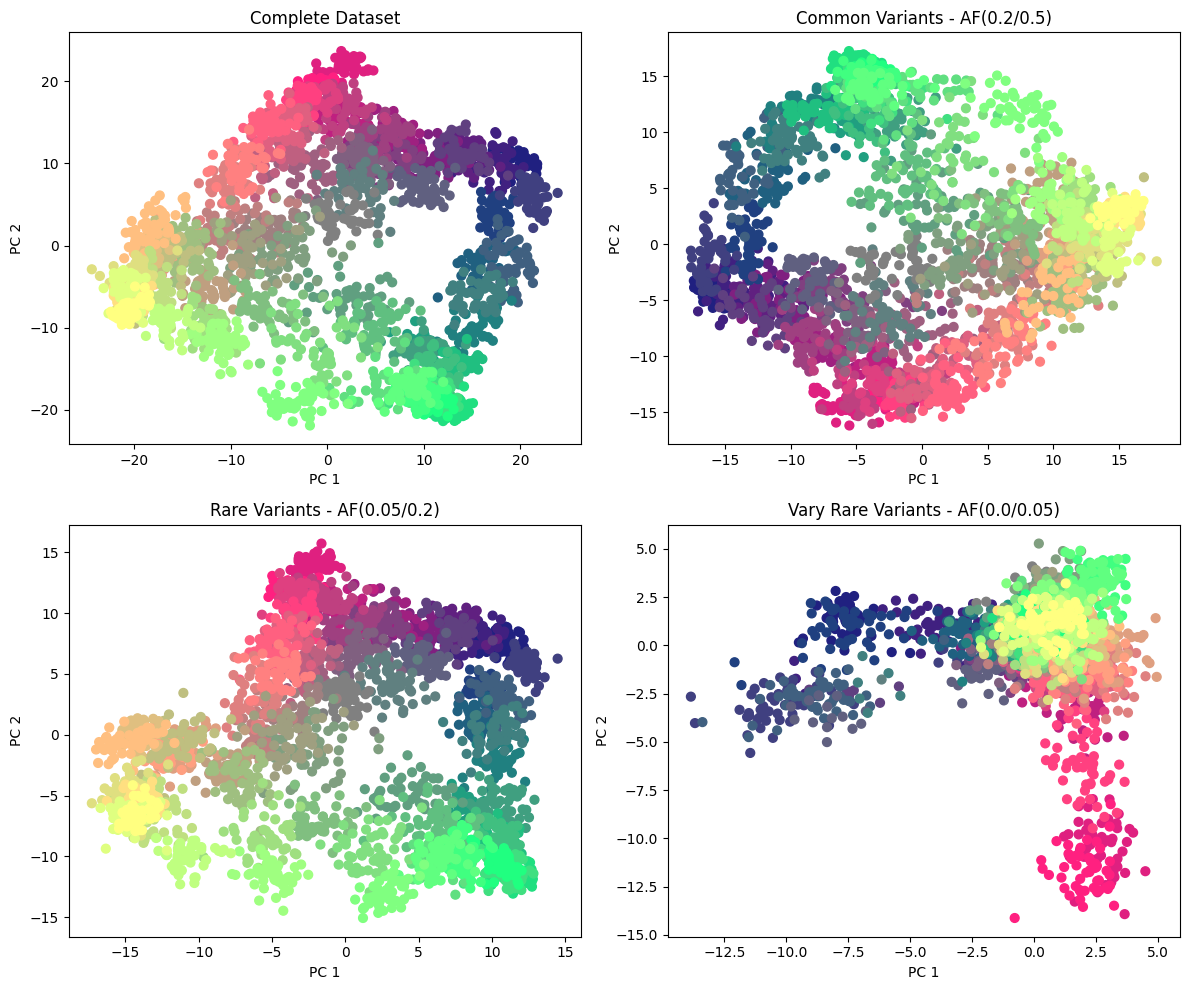

In [15]:
colors = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Dataframes and corresponding titles
dataframes = [PC_complete, PC_common, PC_rare, PC_veryrare]
titles = ['Complete Dataset', 
          f"Common Variants - AF({common_threshold_L}/{common_threshold_H})", 
          f"Rare Variants - AF({rare_threshold_L}/{rare_threshold_H})", 
          f"Vary Rare Variants - AF({very_rare_threshold_L}/{very_rare_threshold_H})"]

# Iterate through dataframes, axes, and titles
for df, ax, title in zip(dataframes, axes.flatten(), titles):
    # Count the unique values in the 'populations' column
    unique_populations = df['populations'].nunique()
    # Plotting the principal components with colors
    ax.scatter(x=df['PC1'], y=df['PC2'], c=colors, s=40)
    
    ax.set_title(title)  # Set the title for the current subplot
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    # Only show the legend if there are 16 or fewer unique populations
    if unique_populations <= 16:
        ax.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.legend([],[], frameon=False) # This hides the legend

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

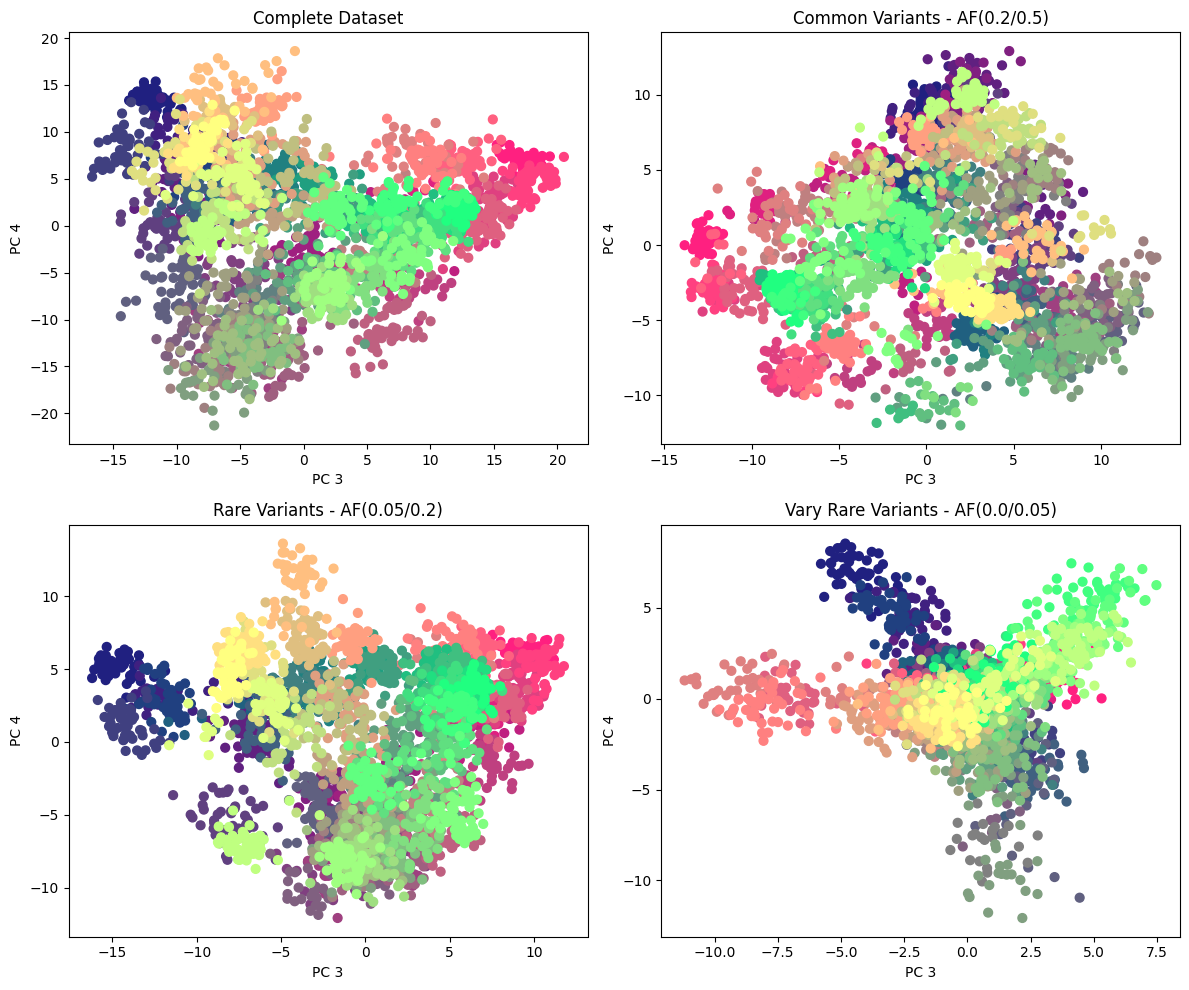

In [16]:
colors = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Dataframes and corresponding titles
dataframes = [PC_complete, PC_common, PC_rare, PC_veryrare]
titles = ['Complete Dataset', 
          f"Common Variants - AF({common_threshold_L}/{common_threshold_H})", 
          f"Rare Variants - AF({rare_threshold_L}/{rare_threshold_H})", 
          f"Vary Rare Variants - AF({very_rare_threshold_L}/{very_rare_threshold_H})"]

# Iterate through dataframes, axes, and titles
for df, ax, title in zip(dataframes, axes.flatten(), titles):
    # Count the unique values in the 'populations' column
    unique_populations = df['populations'].nunique()
    # Plotting the principal components with colors
    ax.scatter(x=df['PC3'], y=df['PC4'], c=colors, s=40)
    
    ax.set_title(title)  # Set the title for the current subplot
    ax.set_xlabel('PC 3')
    ax.set_ylabel('PC 4')
    # Only show the legend if there are 16 or fewer unique populations
    if unique_populations <= 16:
        ax.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.legend([],[], frameon=False) # This hides the legend

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Save PCs

In [17]:
os.makedirs(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs",exist_ok = True)

In [18]:
PC_complete.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/complete_genotypes_AF_0_0.5_.pkl")
PC_veryrare.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
PC_rare.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
PC_common.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")